In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from maddeb.Deblender import Deblend
from maddeb.utils import listdir_fullpath
from maddeb.extraction import extract_cutouts

import numpy as np
import os

import matplotlib.pyplot as plt

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import tensorflow as tf
import tensorflow_probability as tfp
tf.get_logger().setLevel('ERROR')

from maddeb.utils import CustomSampling

2023-01-07 14:51:11.554343: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-01-07 14:51:11.554595: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import seaborn as sns
sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

# Generate the blended scene

In [3]:
COSMOS_CATALOG_PATHS = "/sps/lsst/users/bbiswas/OneDegSq_snr_10.fits"

stamp_size = 41
min_number = 8
max_number = 15
batch_size = 2
maxshift = 15
num_repetations = 15
catalog = btk.catalog.CatsimCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("LSST")
seed = 13
run_name = "test_run_catsim"

linear_norm_coeff = [1000, 5000, 10000, 10000, 10000, 10000]

sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_number, min_number=min_number, max_shift=maxshift, stamp_size=stamp_size, seed=seed
)

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    seed=seed,
)

In [4]:
blend = next(draw_generator)

blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])

Generating blends for LSST survey:   0%|          | 0/2 [00:00<?, ?it/s]

(6, 205, 205)

input_image


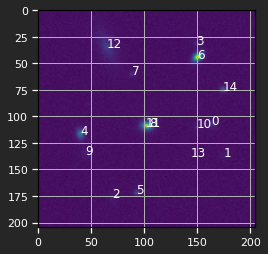

In [5]:
print("input_image")
plt.imshow(blend['blend_images'][0, 2])
for i in range(len(blend['blend_list'][0])):
    plt.text(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], str(i))

input_image


/tmp/ipykernel_11949/2459567947.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  bar = fig.colorbar(im1, ax=ax)


<Figure size 720x720 with 0 Axes>

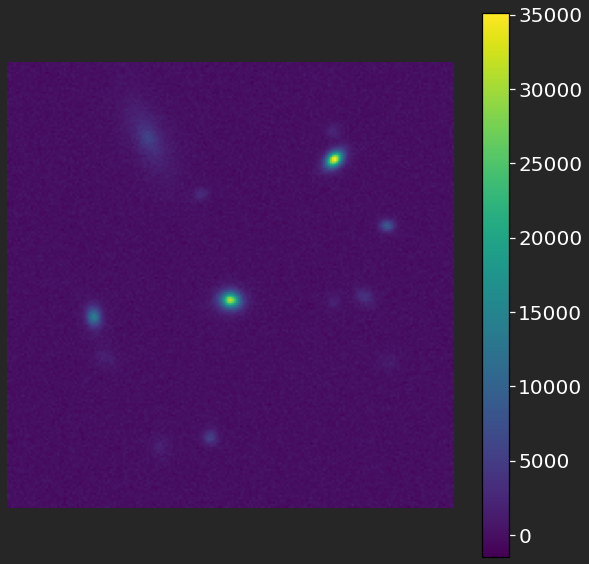

In [6]:
fig = plt.figure(figsize=(10,10))
print("input_image")
fig=plt.figure(figsize=(10,10))
ax=fig.gca()
im1 = ax.imshow(blend['blend_images'][0, 2])
#for i in range(len(blend['blend_list'][0])):
#    plt.scatter(blend['blend_list'][0]['x_peak'][i], 
#                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
    #plt.text(blend['blend_list'][0]['x_peak'][i]-1, blend['blend_list'][0]['y_peak'][i]-1, str(i), c='black', fontsize=15)
bar = fig.colorbar(im1, ax=ax)
bar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("input field")


# Initialize the Deblender

In [7]:
tf.get_logger().setLevel('ERROR')

detected_positions = []
for i in range(len(blend['blend_list'][0])):
    detected_positions.append([blend['blend_list'][0]['y_peak'][i], blend['blend_list'][0]['x_peak'][i]])

deb = Deblend(blend['blend_images'][0], 
              detected_positions,
              latent_dim=16, 
              num_components=len(blend['blend_list'][0]), 
              use_likelihood=True, 
              linear_norm_coeff=linear_norm_coeff,
              max_iter=500)

2023-01-07 14:51:39.972190: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-01-07 14:51:39.972371: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-07 14:51:39.972572: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2023-01-07 14:51:39.973930: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-07 14:51:39.9

0.001


2023-01-07 14:51:50.720171: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Test run Debvader

In [8]:
deb.run_debvader()

In [9]:
# fig, ax = plt.subplots(len(blend['blend_list'][0]), 3, figsize=(5*3,5*len(blend['blend_list'][0])))

# for i in range(len(blend['blend_list'][0])):

#     #print("image number: " + str(i))
#     image_index = i
#     im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i], detected_positions[i], 9))
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 0].set_title("ground truth")
#     ax[i, 0].scatter(22, 22, c="r", marker="x")

#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 1].set_title("predicted")
    
#     im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i], detected_positions[i], 9) - deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im3, ax=ax[i, 2])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 2].set_title("actual - predicted")
    
# plt.show()

/tmp/ipykernel_11949/4083717891.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar =fig.colorbar(im1, ax=ax)


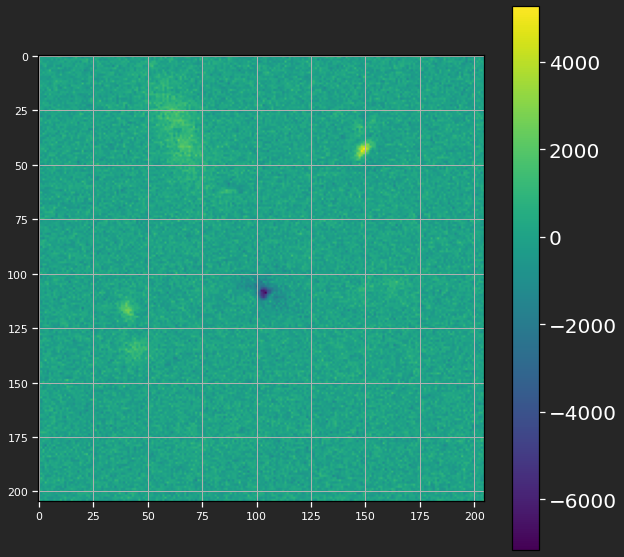

In [10]:
# Residual after debvader run

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
padding_infos = deb.get_padding_infos()
residual = deb.compute_residual(np.transpose(blend['blend_images'][0], axes=[1, 2, 0]), use_scatter_and_sub=True).numpy()
#residual = np.transpose(deb.postage_stamp, 
im1 = ax.imshow(residual[:, :, 3])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.savefig("residual")

In [11]:
# fig, ax = plt.subplots(len(blend['blend_list'][0]), 2, figsize=(5*2,5*len(blend['blend_list'][0])))

# for i in range(len(blend['blend_list'][0])):

#     im1 = ax[i, 0].imshow(extract_cutouts(blend['isolated_images'][0][i], [detected_positions[i]], distances_to_center=False, cutout_size=45)[0][0, :, :, 2])
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=20)
#     ax[i, 0].set_title("ground truth", fontsize=20)
#     ax[i, 0].scatter(22, 22, c="r", marker="x")
#     ax[i, 0].axis('off')


#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=20)
#     ax[i, 1].set_title("predicted", fontsize=20)
#     ax[i, 1].axis('off')

# plt.show()

# Run MADNESS

In [33]:
import tensorflow_addons as tfa
tf.config.run_functions_eagerly(False)
tf.config.run_functions_eagerly(False)
convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(
    atol=0.000001 * 45 * 45 * len(blend) * 3, min_num_steps=100, window_size=20
)
convergence_criterion = tfp.optimizer.convergence_criteria.SuccessiveGradientsAreUncorrelated(min_num_steps=100, window_size=25)
# convergence_criterion = None
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1., decay_steps=20, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
#optimizer=tfa.optimizers.AdaBelief(learning_rate=lr_scheduler)

deb(convergence_criterion, optimizer=optimizer, use_debvader=True, compute_sig_dynamically=False)



Using encoder for initial point

--- Starting gradient descent in the latent space ---
Maximum number of iterations: 500
Number of Galaxies: 15
Dimensions of latent space: 16


143883.797
-31681.6836
143963.469
-17737.6914
135494.531
-8768.61426
134217.859
-4550.58789
134514.5
-3442.88477
134210.047
-3065.07031
133571.859
-2939.97021
133374.906
-2767.69141
133167.969
-2689.02979
132496.562
-2630.98535
131621.609
-2605.36621
130997.305
-2573.10376
130643.93
-2538.59473
130363.359
-2510.10059
130197.883
-2476.47314
130036.977
-2435.94141
129744.055
-2385.14331
129510.234
-2338.28735
129363.414
-2219.0874
129165.734
-2166.96973
128946.312
-2130.48291
128832.703
-2082.10596
128742.312
-2006.51782
128619.727
-1921.47412
128534.906
-1851.3606
128494.062
-1788.56421
128401.609
-1736.51025
128257.875
-1678.47754
128157.008
-1622.34973
128075.844
-1558.72388
128023.859
-1506.44312
128004.766
-1457.28174
127970.195
-1417.78589
127900.125
-1371.56775
127815.297
-1329.84558
127748.195
-1282.45239
127681.094
-1237.13086
127604.375
-1202.1394
127557.75
-1169.79199
127524.969
-1130.07117
127499.703
-1095.37683
127479.445
-1067.99536
127429.875
-1033.25195
127371.742
-1007.7

--- Gradient descent complete ---

Time taken for gradient descent: 54.59674859046936


tf.Tensor(
[175565.48  161701.16  144263.14  138768.45  137957.39  137275.12
 136511.83  136142.6   135857.    135127.55  134226.97  133570.4
 133182.53  132873.45  132674.36  132472.92  132129.2   131848.52
 131582.5   131332.7   131076.8   130914.81  130748.83  130541.2
 130386.266 130282.625 130138.12  129936.35  129779.36  129634.57
 129530.305 129462.05  129387.984 129271.695 129145.14  129030.65
 128918.23  128806.516 128727.54  128655.04  128595.08  128547.44
 128463.125 128379.5   128323.96  128281.68  128227.06  128169.91
 128112.27  128058.46  128012.03  127969.8   127921.13  127876.71
 127836.67  127799.64  127766.91  127734.31  127698.58  127669.75
 127641.14  127609.39  127579.92  127557.09  127546.73  127539.93
 127525.18  127508.37  127494.92  127481.016 127463.54  127448.93
 127440.266 127433.85  127424.84  127412.93  127401.016 127391.766
 127382.86  127373.9   127364.91  127357.17  127348.586 127339.27
 127329.99  127324.12  127320.21  127314.586 127307.21  127299.77


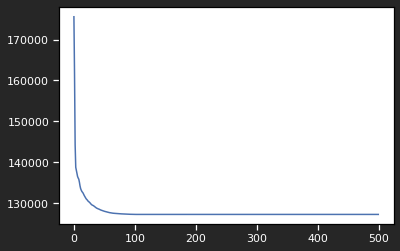

In [34]:
print(deb.results)
plt.plot(deb.results);

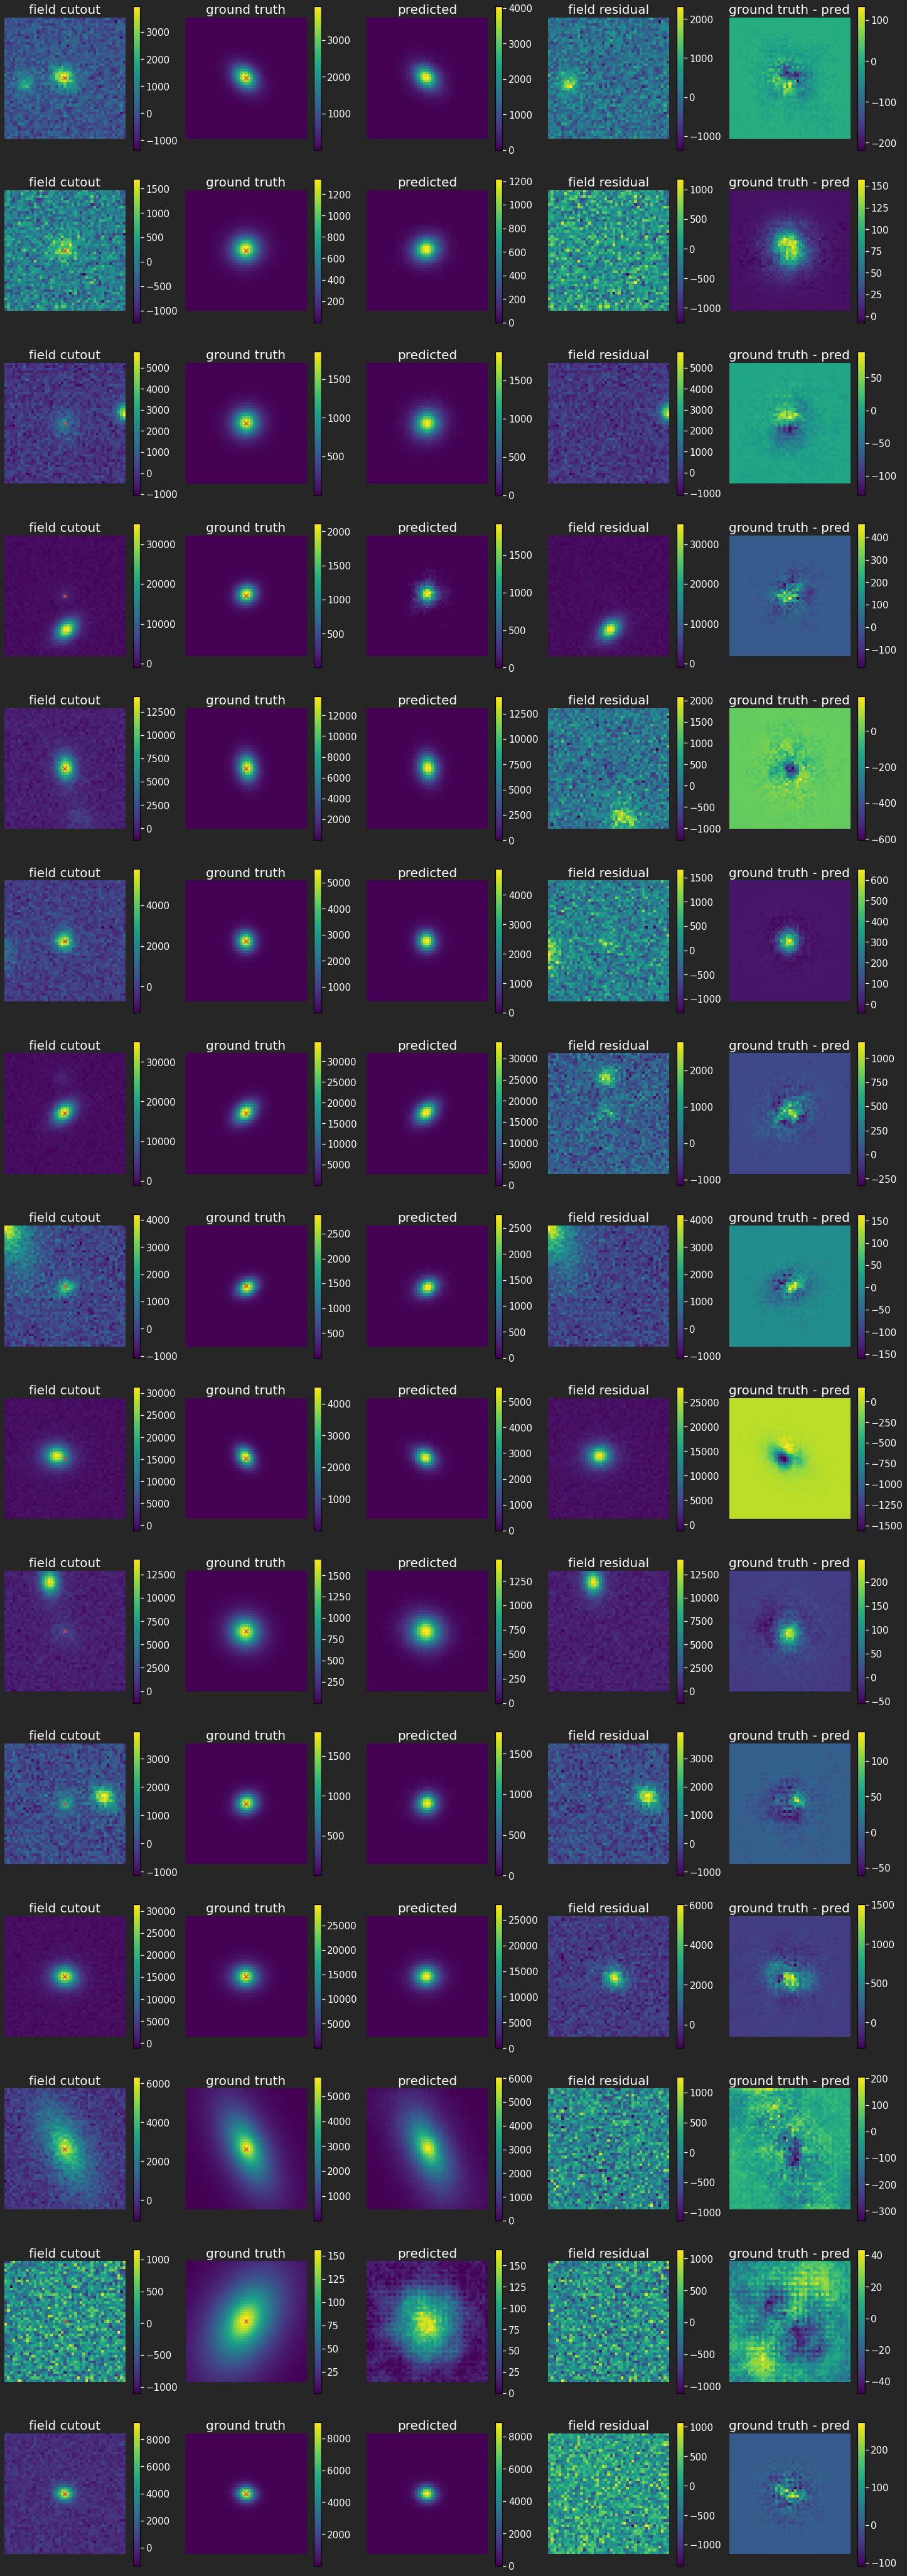

In [35]:
fig, ax = plt.subplots(len(blend['blend_list'][0]), 5, figsize=(5*5,5*len(blend['blend_list'][0])))

for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
    field_cutout_r_band = extract_cutouts(blend['blend_images'][0], [detected_positions[i]], distances_to_center=False, channel_last=False, cutout_size=45)[0][0,:, :, 2]
    galaxy_cutout_r_band = extract_cutouts(blend['isolated_images'][0][i], [detected_positions[i]], distances_to_center=False, cutout_size=45)[0][0, :, :, 2]
    
    im1 = ax[i, 0].imshow(field_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 0].set_title("field cutout", fontsize=20)
    ax[i, 0].scatter(22, 22, c="r", marker="x")
    ax[i, 0].axis('off')

    im1 = ax[i, 1].imshow(galaxy_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 1].set_title("ground truth", fontsize=20)
    ax[i, 1].scatter(22, 22, c="r", marker="x")
    ax[i, 1].axis('off')


    im2 = ax[i, 2].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 2])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 2].set_title("predicted", fontsize=20)
    ax[i, 2].axis('off')
    
    im3 = ax[i, 3].imshow(field_cutout_r_band - deb.components[i][:, :, 2])
    cbar = fig.colorbar(im3, ax=ax[i, 3])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 3].set_title("field residual", fontsize=20)
    ax[i, 3].axis('off')

    
    im3 = ax[i, 4].imshow(galaxy_cutout_r_band - deb.components[i][:, :, 2])
    cbar = fig.colorbar(im3, ax=ax[i, 4])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 4].set_title("ground truth - pred", fontsize=20)
    ax[i, 4].axis('off')

plt.savefig("MAP_predictions")
plt.show()

In [36]:
# fig, ax = plt.subplots(1, len(blend['blend_list'][0]), figsize=(5*len(blend['blend_list'][0]), 5*1))
# for i in range(len(blend['blend_list'][0])):

#     #print("image number: " + str(i))
#     #image_index = shuffled_indices[i]

#     im2 = ax[i].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i].axis("off")
#     #ax[i].set_title("predicted")
# plt.savefig("predictions")

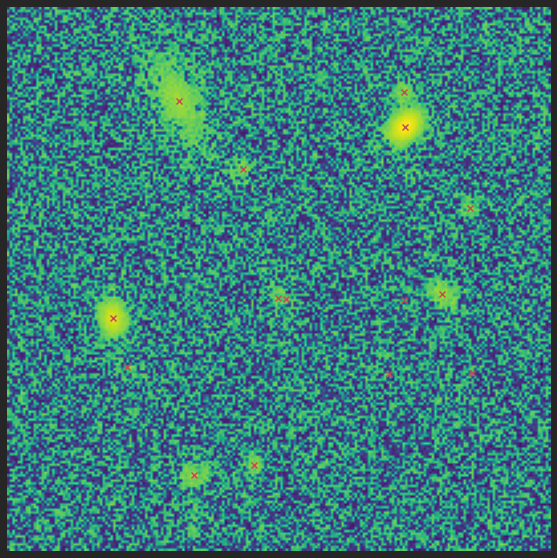

In [37]:
# This is just to make the blends more visible

sns.set_theme(style={"axes.grid": False,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.arcsinh(blend['blend_images'][0][0]))
for i in range(len(blend['blend_list'][0])):
    plt.scatter(blend['blend_list'][0]['x_peak'][i], 
                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")

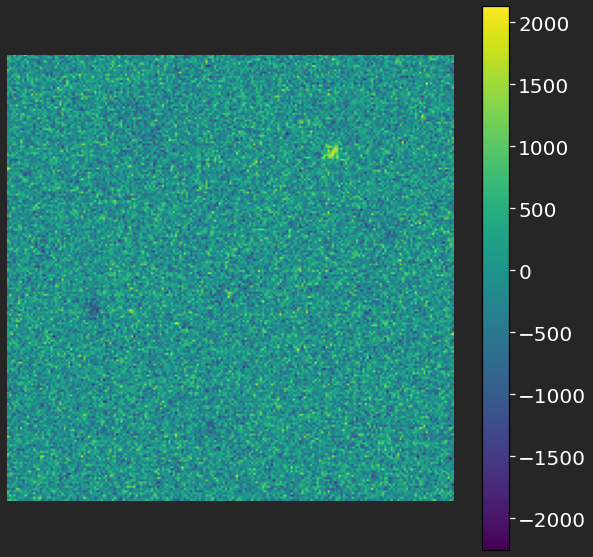

In [38]:
# Residual after MADNESS run
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
tf.config.run_functions_eagerly(True)

padding_infos = deb.get_padding_infos()
residual = deb.compute_residual(np.transpose(blend['blend_images'][0], axes=[1, 2, 0]), use_scatter_and_sub=True).numpy()
#residual = np.transpose(deb.postage_stamp, 
im1 = ax.imshow(residual[:, :, 5])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("residual")

#for i in range(len(blend['blend_list'][0])):
    #plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

##### sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

plt.figure(figsize=(8,3))
residual_flattened = residual[:, :, 0].flatten()
print(np.shape(residual_flattened))
plt.hist(residual_flattened, bins=50)
plt.xticks(fontsize=15)
plt.yticks([])

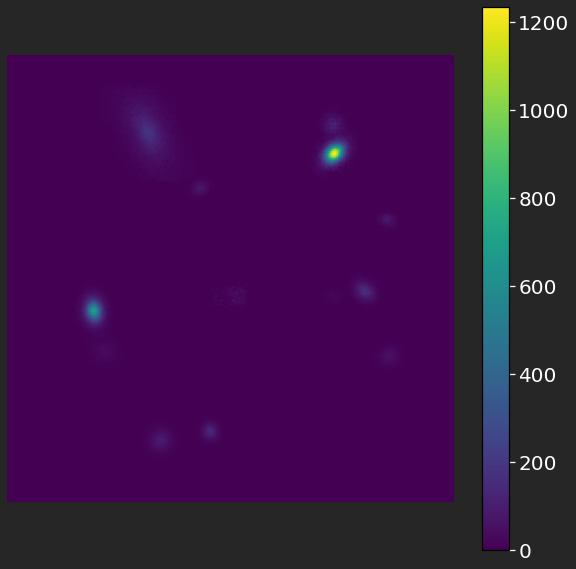

In [39]:
sns.set_theme(style={"axes.grid": False,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})
predicted_field = blend['blend_images'][0] - np.transpose(residual, axes=[2, 0, 1])
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
im1 = ax.imshow(predicted_field[0, :, :])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.show();

In [19]:
from maddeb.metrics import compute_reconstruction_metrics
from maddeb.extraction import extract_cutouts

In [20]:
field_size = np.shape(blend['isolated_images'][0][i])[1]

In [21]:
field_image=blend['blend_images'][0]

In [22]:
cutouts, list_idx = extract_cutouts(field_image=blend['blend_images'][0], pos=np.array(detected_positions), cutout_size=45, channel_last=False)

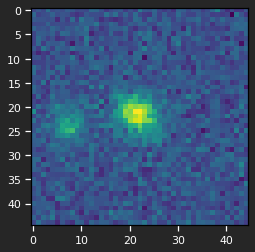

In [23]:
plt.imshow(cutouts[0][:, :, 2])

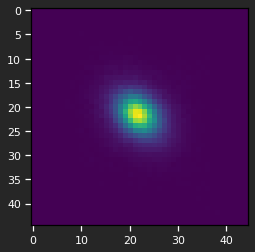

In [24]:
plt.imshow(deb.components[0][:, :, 2])

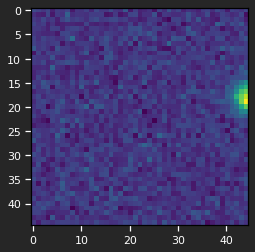

In [25]:
plt.imshow(cutouts[2][:, :, 2]-deb.components[2][:, :, 2])

In [26]:
results=compute_reconstruction_metrics(deb.components, cutouts)

TypeError: Cannot interpret 'tf.float32' as a data type

In [ ]:
plt.hist(results["mse"]);

In [ ]:
plt.hist(results["psnr"]);

In [ ]:
plt.hist(results["ssim"]);